In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm #맷플롯립에서 colormap을 불러옴 : 데이터 값에 따라 색상으로 표현
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade
#더 균일한 랜덤 분포를 얻는 qmc

In [44]:
tf.keras.backend.set_floatx("float64") #keras의 기본 데이터타입을 설정하는 함수 기본값: float32 -> float64(더 정확)

In [45]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
N_0 = 50  #초기조건 데이터
N_b = 50 #경계조건 데이터 = N_b

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #1차원 샘플을 만들어줄 엔진(인스턴스)생성

# temporal data points
t_d_zero = np.zeros([N_0,1])
t_d_b = engine.random(n=N_b)
t_d_b = np.pi * t_d_b
# spatial data points
x_d_zero = engine.random(n=N_0)
x_d_zero = 10 * (x_d_zero - 0.5) #기본적으로 qmc는 0,1 사이의 난수를 생성 하므로 -5,5 범위로 난수 스케일링

x_d_five = 5 * np.ones([N_b,1])
x_d_mfive = -5 * np.ones([N_b,1])
#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

In [46]:
# output values for data points (boundary and initial)
u_d_zero = np.zeros(x_d_zero.shape) #initializing the array y_d
v_d_zero = np.zeros(x_d_zero.shape) #done

# for initial condition: IC = -sin(pi*x)
u_d_zero = 2/(np.cosh(x_d_zero)) #앞의 50개의 데이터인 초기조건 데이터들에 대한 함수값을 초기조건에 맞게설정

In [47]:
# number of collocation points
N_f = 20000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=N_f)
# set x values between -1. and +1.
data[:, 1] = 10*(data[:, 1]-0.5) #x값들이 도메인 안에 들어가도록 스케일링

# change names #t,x데이터들 분리하기.
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [48]:
# convert all data and collocation points to tf.Tensor
t_d_zero, t_d_b, x_d_zero, x_d_five, x_d_mfive,u_d_zero, v_d_zero = map(tf.convert_to_tensor, [t_d_zero, t_d_b, x_d_zero, x_d_five, x_d_mfive,u_d_zero, v_d_zero])

In [49]:
### model design
#
neuron_per_layer = 100
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,)) #[a,b]형태의 입력값이 들어간다 즉 두개의 feature을 가지는 데이터를 입력시키는것.

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)


# output layer
output_layer = tf.keras.layers.Dense(2, activation=None)(hidden5)

model = tf.keras.Model(input_layer, output_layer) #입력층과 출력층만 지정하면 되는이유: tf는 자동으로 레이어 간 연결을 추적하기 때문

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,002 (398.45 KB)

 Trainable params: 51,002 (398.45 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    """
    u(t, x): 모델 출력의 첫 번째 값
    """
    inputs = tf.concat([t, x], axis=1)  # [t, x] 결합
    uv = model(inputs)  # 모델 실행
    u = uv[:, 0:1]  # 첫 번째 출력
    return u


#즉 함숫값을 반환하는 함수

In [51]:
@tf.function
def v(t, x):
    """
    v(t, x): 모델 출력의 두 번째 값
    """
    inputs = tf.concat([t, x], axis=1)  # [t, x] 결합
    uv = model(inputs)  # 모델 실행
    v = uv[:, 1:2]  # 두 번째 출력
    return v

In [52]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f_u(t, x):    
    u0 = u(t, x)
    v0 = v(t,x)
    u_t = tf.gradients(u0, t)[0]
    v_x = tf.gradients(v0, x)[0]
    v_xx = tf.gradients(v_x, x)[0]
    F_u = u_t +0.5*v_xx+(u0**2+v0**2)*v0
    return tf.reduce_mean(tf.square(F_u)) #MSE_f 반환  
#텐서플로우 1에서 주로 사용하는 gradient 메소드를 이용해서 미분 구현

In [53]:
@tf.function
def f_v(t, x):    
    u0 = u(t, x)
    v0 = v(t,x)
    v_t = tf.gradients(v0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F_v = -v_t +0.5*u_xx+(u0**2+v0**2)*v0
    return tf.reduce_mean(tf.square(F_v)) #MSE_f 반환  

In [54]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    
    return tf.reduce_mean(tf.square(y-y_))  #MSE_y 반환

In [55]:
@tf.function
def mse_b_u(five, mfive, t):
    u0_five = u(t, five)
    u_x_five = tf.gradients(u0_five,five)[0]
    u0_mfive = u(t,mfive)
    u_x_mfive =tf.gradients(u0_mfive,mfive)[0]
    f=u_x_five - u_x_mfive
    return tf.reduce_mean(tf.square(f))
    

In [56]:
@tf.function
def mse_b_v(five, mfive, t):
    v0_five = v(t, five)
    v_x_five = tf.gradients(v0_five,five)[0]
    v0_mfive = u(t,mfive)
    v_x_mfive =tf.gradients(v0_mfive,mfive)[0]
    f=v_x_five - v_x_mfive
    return tf.reduce_mean(tf.square(f))

In [57]:
import time #경과시간 측정을 위한 모듈 호출

In [60]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 2000 #epochs : 반복횟수
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4) 
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction!
        y_0_u_pred = u(t_d_zero, x_d_zero)
        y_0_v_pred = v(t_d_zero, x_d_zero)
        y_b_five_u_pred = u(t_d_b,x_d_five)
        y_b_mfive_u_pred = u(t_d_b, x_d_mfive)
        y_b_five_v_pred = v(t_d_b,x_d_five)
        y_b_mfive_v_pred = v(t_d_b, x_d_mfive)
        # physics-informed loss for collocation points
        L1 = f_u(t_c, x_c)
        L2 = f_v(t_c, x_c)
        L3 = mse(u_d_zero,y_0_u_pred)
        L4 = mse(v_d_zero,y_0_v_pred)
        L5 = mse(y_b_five_u_pred,y_b_mfive_u_pred)
        L6 = mse(y_b_five_v_pred,y_b_mfive_v_pred)
        L7 = mse_b_u(x_d_five,x_d_mfive,t_d_b)
        L8 = mse_b_v(x_d_five,x_d_mfive,t_d_b)
        loss = L1 + L2 + L3 + L4 + L5 + L6 + L7 + L8
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.298
  10 0.389
  20 0.251
  30 0.184
  40 0.130
  50 0.087
  60 0.054
  70 0.034
  80 0.024
  90 0.020
 100 0.018
 110 0.016
 120 0.015
 130 0.014
 140 0.013
 150 0.013
 160 0.012
 170 0.012
 180 0.011
 190 0.011
 200 0.010
 210 0.010
 220 0.010
 230 0.010
 240 0.009
 250 0.009
 260 0.009
 270 0.009
 280 0.009
 290 0.009
 300 0.009
 310 0.009
 320 0.008
 330 0.008
 340 0.008
 350 0.008
 360 0.008
 370 0.008
 380 0.008
 390 0.008
 400 0.008
 410 0.008
 420 0.008
 430 0.008
 440 0.007
 450 0.007
 460 0.007
 470 0.007
 480 0.007
 490 0.007
 500 0.007
 510 0.007
 520 0.007
 530 0.007
 540 0.007
 550 0.013
 560 0.011
 570 0.007
 580 0.007
 590 0.007
 600 0.007
 610 0.007
 620 0.007
 630 0.006
 640 0.006
 650 0.006
 660 0.006
 670 0.006
 680 0.006
 690 0.006
 700 0.006
 710 0.006
 720 0.006
 730 0.006
 740 0.006
 750 0.006
 760 0.006
 770 0.006
 780 0.006
 790 0.006
 800 0.006
 810 0.006
 820 0.006
 830 0.006
 840 0.006
 850 0.006
 860 0.006
 870 0.006
 880 0.006
 890 0.006
 900 0.006

Text(0.5, 0, 'epoch')

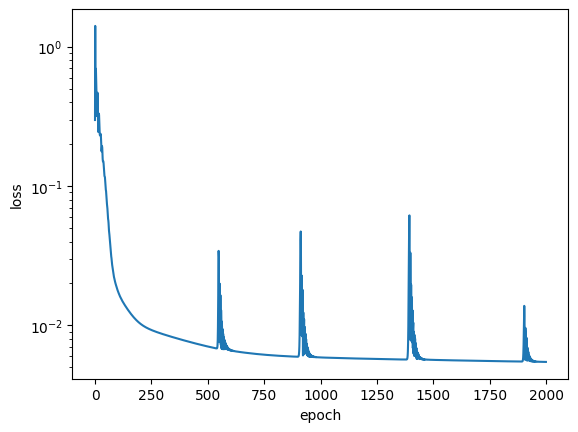

In [61]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

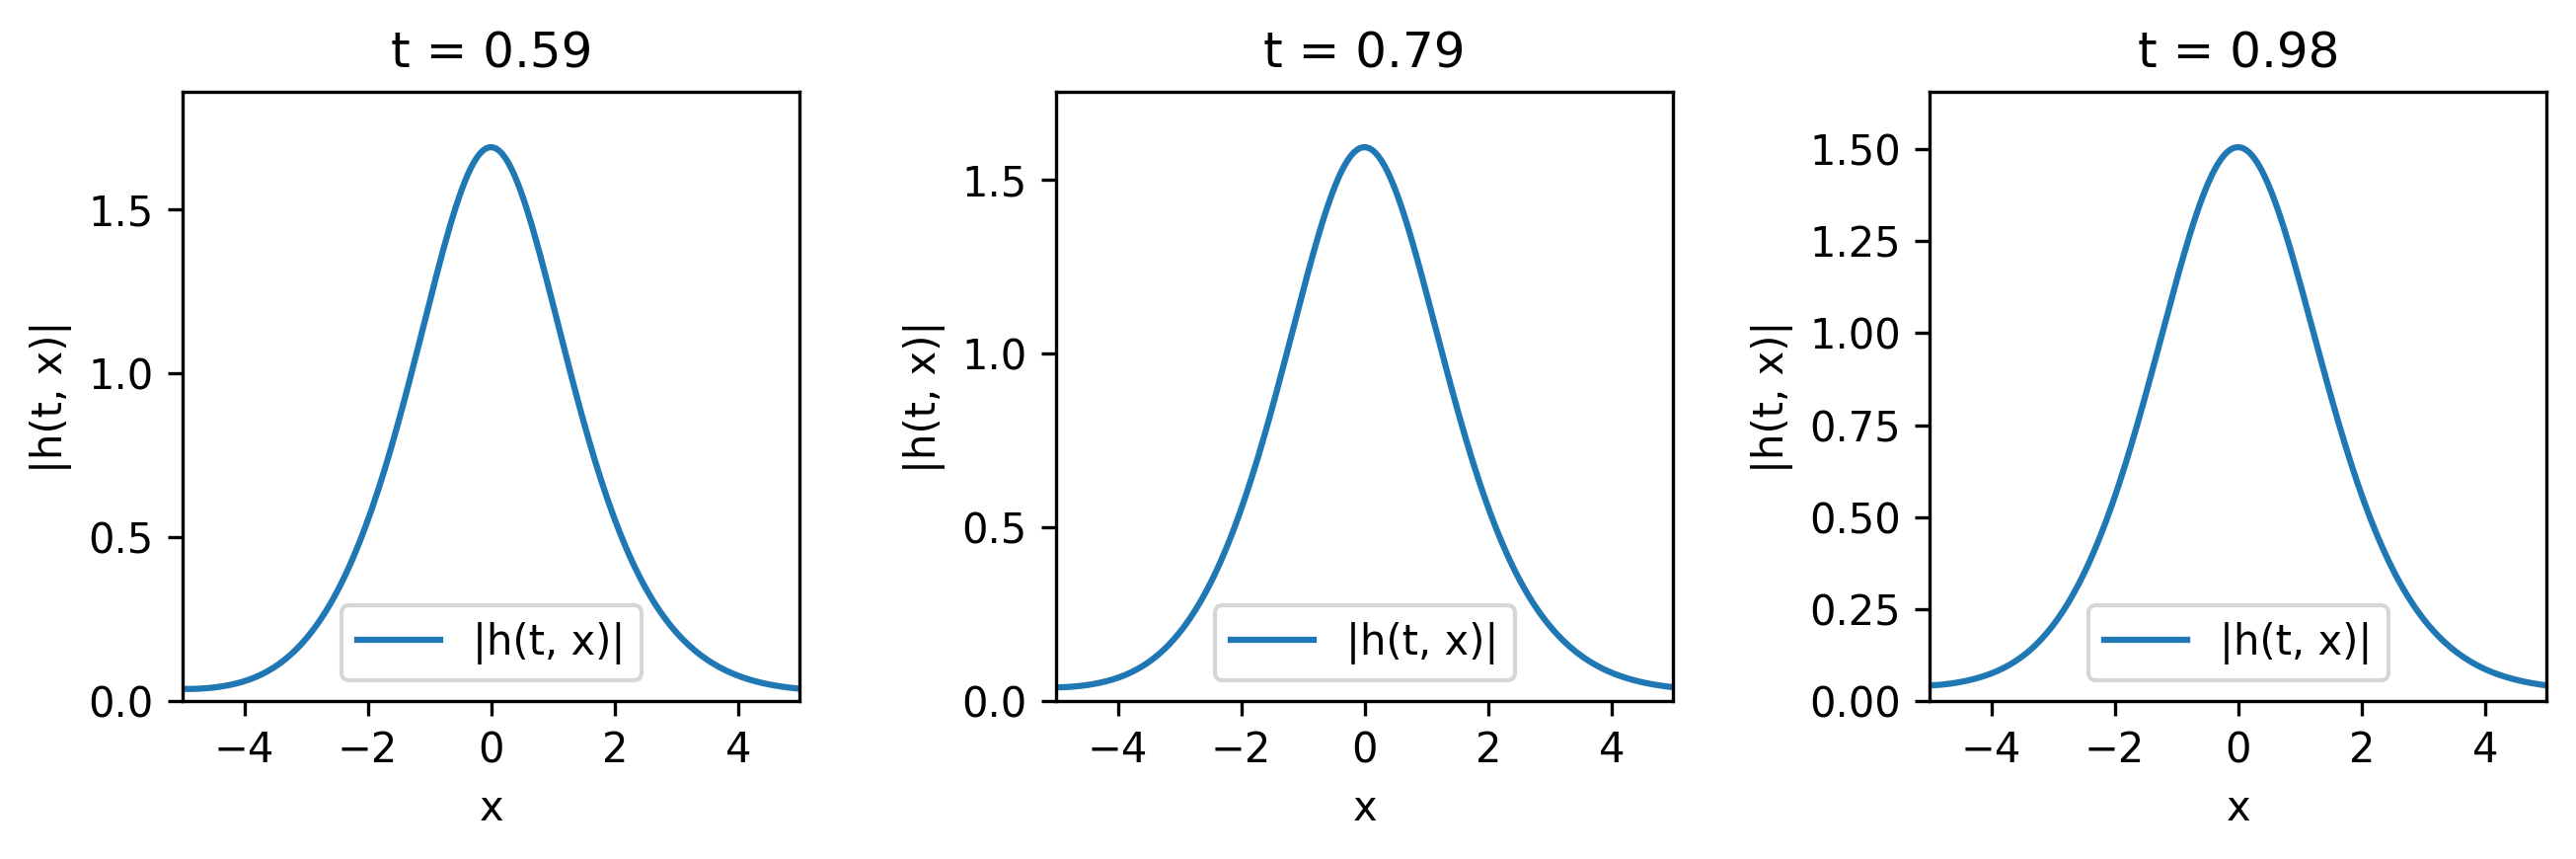

In [64]:
x = np.expand_dims(np.linspace(-5, +5, 200), axis=1)  # x 범위: -5에서 5까지

plt.figure(figsize=(9, 3), dpi=300)

# 정의된 t 값
time_points = [0.59, 0.79, 0.98]

for i, time_point in enumerate(time_points, start=1):
    t = np.ones_like(x) * time_point  # t 값 생성
    u_values = u(t, x).numpy()       # u(t, x) 계산
    v_values = v(t, x).numpy()       # v(t, x) 계산
    h_abs = np.sqrt(u_values**2 + v_values**2)  # |h(t, x)| 계산
    
    plt.subplot(1, 3, i)
    plt.title(f"t = {time_point}")
    plt.plot(x, h_abs, label="|h(t, x)|")
    plt.ylabel(f"|h(t, x)|")
    plt.xlabel(f"x")
    plt.xlim(-5, +5)  # x 범위를 -5에서 5로 설정
    plt.ylim(0, max(h_abs) * 1.1)  # y 축은 데이터 값보다 약간 크게 설정
    plt.legend()

plt.tight_layout()
plt.savefig("h-vs-x.png")
plt.show()


In [ ]:
# save and copy model to drive

model.save("burgers0.h5")
! cp burgers0.h5 drive/MyDrive

'cp'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
